In [40]:
# import necessary libraries

import numpy as np  # Import NumPy for numerical operations
import pandas as pd  # Import Pandas for data manipulation
import tensorflow as tf  # Import TensorFlow for building neural network models
import seaborn as sns  # Import Seaborn for statistical plotting
import matplotlib.pyplot as plt  # Import Matplotlib for creating plots
from sklearn.model_selection import train_test_split  # Import train_test_split for splitting datasets
from sklearn.metrics import mean_squared_error, r2_score  # Import metrics for evaluating models
from sklearn.linear_model import LinearRegression, HuberRegressor, ElasticNet  # Import linear regression models
from sklearn.decomposition import PCA  # Import PCA for dimensionality reduction
from sklearn.cross_decomposition import PLSRegression  # Import PLSRegression for partial least squares regression
from sklearn.preprocessing import SplineTransformer, StandardScaler  # Import SplineTransformer for spline feature transformation
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor  # Import ensemble regression models
from scipy.stats import t # Import t-distribution for statistical tests

plt.style.use('seaborn-v0_8-whitegrid')  # Set the plotting style to Seaborn whitegrid
plt.rcParams['figure.figsize'] = (12, 8)  # Set default figure size for plots to 12x8 inches

# Data Generation

In [41]:
# basic variables
n_stocks = 10
n_months = 24
n_characteristics = 5
n_macro_factors = 3

np.random.seed(42)
stock_characteristics = np.random.rand(n_stocks, n_months, n_characteristics)  # Generate random stock characteristic data
macro_factors = np.random.rand(n_months, n_macro_factors)  # Generate random macroeconomic factor data

zi_t = np.zeros((n_stocks, n_months, n_characteristics * n_macro_factors)) 
for j in range(n_months):
    for i in range(n_stocks):
        zi_t[i, j] = np.outer(macro_factors[j],stock_characteristics[i, j]).flatten() 

# simple linear model for excess return
theta = np.random.rand(n_characteristics * n_macro_factors)
ri_t_plus_1 = np.zeros((n_stocks, n_months))
for j in range(n_months):
    for i in range(n_stocks):
        ri_t_plus_1[i, j] = zi_t[i, j].dot(theta) + np.random.normal(0, 0.05)

# flatten for models
zi_t_flattened = zi_t.reshape(n_stocks * n_months, -1)
ri_t_flattened = ri_t_plus_1.flatten()

# create a dataframe
zi_t_df = pd.DataFrame(zi_t_flattened, columns=[f"z_{k+1}" for k in range(zi_t_flattened.shape[1])])
zi_t_df["Stock_ID"] = np.repeat(range(1, n_stocks + 1), n_months)
zi_t_df["Month"] = np.tile(range(1, n_months + 1), n_stocks)


ri_t_df = pd.DataFrame({
    "Stock_ID": np.repeat(range(1, n_stocks + 1), n_months),
    "Month": np.tile(range(1, n_months + 1), n_stocks),
    "Excess_Return": ri_t_flattened,
    "Weights": np.random.rand(n_stocks * n_months)
})

combined_data = pd.concat([zi_t_df, ri_t_df[["Excess_Return", "Weights"]]], axis=1)

combined_data.to_csv("data/combined_dataframe.csv", index=False)

In [42]:
data = pd.read_csv("data/combined_dataframe.csv")

data.head()

,z_1,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,z_10,z_11,z_12,z_13,z_14,z_15,Stock_ID,Month,Excess_Return,Weights
0,0.284000,0.720892,0.555044,0.453941,0.118303,0.009209,0.023375,0.017997,0.014719,0.003836,0.008286,0.021033,0.016194,0.013244,0.003452,1,1,0.630027,0.717598
1,0.050481,0.018796,0.280303,0.194527,0.229140,0.076226,0.028382,0.423251,0.293731,0.345995,0.120179,0.044748,0.667309,0.463103,0.545504,1,2,1.552710,0.692436
2,0.014065,0.662735,0.568804,0.145090,0.124240,0.009179,0.432485,0.371188,0.094683,0.081076,0.005632,0.265393,0.227779,0.058102,0.049752,1,3,0.831843,0.991256
3,0.182877,0.303367,0.523247,0.430703,0.290392,0.078164,0.129662,0.223641,0.184087,0.124116,0.082786,0.137331,0.236868,0.194974,0.131457,1,4,1.315436,0.128394
4,0.100114,0.022825,0.047802,0.059946,0.074624,0.486307,0.110871,0.232199,0.291188,0.362489,0.424431,0.096764,0.202656,0.254139,0.316368,1,5,1.683045,0.104110


# Train-Test Split

In [43]:
# build training, validation and testing sets
X_full = data[[col for col in data.columns if col.startswith("z_")]]
Y_full = data["Excess_Return"]

X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X_full, Y_full, test_size=0.3, random_state=42
)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_trainval, Y_trainval, test_size=0.2857, random_state=42
)

# Model Training Section

In [44]:
# OLS Regression
ols_model = LinearRegression()
ols_model.fit(X_train, Y_train)

# Weighted Linear Regression
weighted_ols_model = LinearRegression()
weighted_ols_model.fit(X_train, Y_train, sample_weight=np.random.rand(len(Y_train)))    

# HUber Regression
huber_model = HuberRegressor()
huber_model.fit(X_train, Y_train)

# Elastic Net Regression
best_mse = float('inf')
best_alpha = None
best_l1_ratio = None

for alpha in [0.01, 0.1, 1.0, 10.0]:
    for l1_ratio in [0.1, 0.5, 0.9]:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, max_iter=1000, random_state=42)
        model.fit(X_train, Y_train)
        y_val_pred = model.predict(X_val)
        val_mse = mean_squared_error(Y_val, y_val_pred)

        if val_mse < best_mse:
            best_mse = val_mse
            best_alpha = alpha
            best_l1_ratio = l1_ratio

elastic_net_model = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, fit_intercept=True, max_iter=1000, random_state=42)
elastic_net_model.fit(X_train, Y_train)

# PCR Regression
best_pcr_mse = float('inf')
best_n_components = None
for n_components in range(1, min(X_train.shape[1], 20) + 1):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)

    lr_pcr = LinearRegression()
    lr_pcr.fit(X_train_pca, Y_train)
    
    y_val_pred = lr_pcr.predict(X_val_pca)
    mse = mean_squared_error(Y_val, y_val_pred)

    if mse < best_pcr_mse:
        best_pcr_mse = val_mse
        best_n_components = n_components

pca_model = PCA(n_components=best_n_components)
X_train_pca = pca_model.fit_transform(X_train)
lr_pcr_model = LinearRegression()
lr_pcr_model.fit(X_train_pca, Y_train)

# PLS Regression
best_pls_mse = float('inf')
best_n_components_pls = None
for n_components in range(1, min(X_train.shape[1], 20) + 1):
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_train, Y_train)
    
    y_val_pred = pls.predict(X_val)
    mse = mean_squared_error(Y_val, y_val_pred)

    if mse < best_pls_mse:
        best_pls_mse = mse
        best_n_components_pls = n_components

pls_model = PLSRegression(n_components=best_n_components_pls)
pls_model.fit(X_train, Y_train)

# Generalized Linear Model
spline_transformer = SplineTransformer(n_knots=5, degree=2, include_bias=False, knots="uniform")
X_train_spline = spline_transformer.fit_transform(X_train)
X_val_spline = spline_transformer.transform(X_val)

l1_ratios = [0.1, 0.5, 0.9]
alphas = np.logspace(-3, 1, 10)
best_model = None
best_val_mse = float('inf')
for l1_ratio in l1_ratios:
    for alpha in alphas:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True, max_iter=1000, random_state=42)
        model.fit(X_train_spline, Y_train)
        
        y_val_pred = model.predict(X_val_spline)
        val_mse = mean_squared_error(Y_val, y_val_pred)

        if val_mse < best_val_mse:
            best_val_mse = val_mse
            best_model = model

glm_model = best_model

# Neural Network Model

def create_model(learning_rate=0.01, neurons_layer1=32, neurons_layer2=16, neurons_layer3=8):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(zi_t_flattened.shape[1],)),
        tf.keras.layers.Dense(neurons_layer1, activation='relu'),
        tf.keras.layers.Dense(neurons_layer2, activation='relu'),
        tf.keras.layers.Dense(neurons_layer3, activation='relu'),
        tf.keras.layers.Dense(1) 
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

best_model = None
best_val_loss = float('inf')
learning_rates = [0.001, 0.01, 0.1]
neurons_layer1_options = [32, 64]
neurons_layer2_options = [16, 32]
neurons_layer3_options = [8, 16]

for lr in learning_rates:
    for n1 in neurons_layer1_options:
        for n2 in neurons_layer2_options:
            for n3 in neurons_layer3_options:
                model = create_model(learning_rate=lr, 
                                     neurons_layer1=n1, 
                                     neurons_layer2=n2, 
                                     neurons_layer3=n3)
                
                history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, batch_size=32, verbose=0, callbacks=[
                    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
                ])
                
                val_loss = min(history.history['val_loss'])
                
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model

nn_model = best_model

# Gradient Boosting Regressor
brt_best_params = None
brt_best_model = None
brt_best_rmse = float('inf')

for n_estimators in [50, 100, 200]:
    for learning_rate in [0.01, 0.1, 0.2]:
        for max_depth in [3, 5, 7]:
            model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
            model.fit(X_train, Y_train)
            val_pred = model.predict(X_val)
            val_rmse = np.sqrt(mean_squared_error(Y_val, val_pred))

            if val_rmse < brt_best_rmse:
                brt_best_rmse = val_rmse
                brt_best_params = {"n_estimators":n_estimators, "learning_rate": learning_rate, "max_depth": max_depth}
                brt_best_model = model

brt_model = brt_best_model

# Random Forest Regressor
rf_best_params = None
rf_best_model = None
rf_best_rmse = float('inf')

for n_estimators in [50, 100, 200]:
    for max_depth in [3, 5, 7]:
        for min_samples_split in [2, 5, 10]:
            model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
            model.fit(X_train, Y_train)
            val_pred = model.predict(X_val)
            val_rmse = np.sqrt(mean_squared_error(Y_val, val_pred))

            if val_rmse < rf_best_rmse:
                rf_best_rmse = val_rmse
                rf_best_params = {"n_estimators": n_estimators, "max_depth": max_depth, "min_samples_split": min_samples_split}
                rf_best_model = model

rf_model = rf_best_model

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is 

# Prediction Wrapper

In [45]:
def predict_all_models(X):
    
    return {
        "OLS": ols_model.predict(X),
        "Weighted OLS": weighted_ols_model.predict(X),
        "Huber": huber_model.predict(X),
        "Elastic Net": elastic_net_model.predict(X),
        "PCR": lr_pcr_model.predict(pca_model.transform(X)),
        "PLS": pls_model.predict(X).flatten(),
        "Generalized_Linear_Model": glm_model.predict(spline_transformer.transform(X)),
        "Neural_Network": nn_model.predict(X).flatten(),
        "Boosted_Regression_Trees": brt_model.predict(X),
        "Random_Forest": rf_model.predict(X)
    }

prediction = predict_all_models(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


# Out-of-Sample R²

In [46]:
def calc_r2(Y_true, Y_pred):
     ss_res = np.sum((Y_true - Y_pred) ** 2)
     ss_tot = np.sum((Y_true - np.mean(Y_true)) ** 2)
     return 1 - (ss_res / ss_tot)

r2_results = {name: calc_r2(Y_test, pred) for name, pred in prediction.items()}
df_r2 = pd.DataFrame.from_dict(r2_results, orient='index', columns=['R²']).to_csv("/Users/dennis/Documents/Uni/FDS/PS6/data/r2_results.csv")

In [47]:
r2_data = pd.read_csv("/Users/dennis/Documents/Uni/FDS/PS6/data/r2_results.csv")

r2_data.head(10)

,Unnamed: 0,R²
0,OLS,0.996831
1,Weighted OLS,0.996354
2,Huber,0.996605
3,Elastic Net,0.990315
4,PCR,0.996831
5,PLS,0.996876
6,Generalized_Linear_Model,0.990550
7,Neural_Network,0.990352
8,Boosted_Regression_Trees,0.929344
9,Random_Forest,0.889388


# Diebold-Mariano Test

In [48]:
def diebold_mariano_test(Y_true, pred_1, pred_2):
    """
    Perform the Diebold-Mariano test for comparing two predictive models.
    
    Parameters:
    Y_true : array-like
        True values of the dependent variable.
    pred_1 : array-like
        Predictions from the first model.
    pred_2 : array-like
        Predictions from the second model.
    
    Returns:
    dm_statistic : float
        Diebold-Mariano test statistic.
    p_value : float
        p-value of the Diebold-Mariano test.
    """
    e1 = Y_true - pred_1
    e2 = Y_true - pred_2
    diff = e1 ** 2 - e2 ** 2
    dm_statistic = np.mean(diff) / np.sqrt(np.var(diff) / len(Y_true))
    p_value = 2 * (1 - t.cdf(np.abs(dm_statistic), df=len(diff)-1))
    return dm_statistic, p_value

In [49]:
def compare_models(Y_true, predictions):
    df_diebold_mariano = pd.DataFrame(columns=['Model1', 'Model2', 'DM Statistic', 'p-value'])
    models = list(predictions.keys())
    for i in range(len(models)):
        for j in range(len(models)):
            model1 = models[i]
            model2 = models[j]
            dm_statistic, p_value = diebold_mariano_test(Y_true, predictions[model1], predictions[model2])
            df_diebold_mariano = df_diebold_mariano._append({
                'Model1': model1,
                'Model2': model2,
                'DM Statistic': dm_statistic,
                'p-value': p_value
            }, ignore_index=True)
    return df_diebold_mariano

In [50]:
# Perform the Diebold-Mariano test for all model pairs
df_diebold_mariano = compare_models(Y_test, prediction)
df_diebold_mariano.to_csv("/Users/dennis/Documents/Uni/FDS/PS6/data/diebold_mariano_results.csv", index=False)

/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_19686/3100594750.py:22: RuntimeWarning: invalid value encountered in scalar divide
  dm_statistic = np.mean(diff) / np.sqrt(np.var(diff) / len(Y_true))
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_19686/161944753.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_diebold_mariano = df_diebold_mariano._append({
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_19686/3100594750.py:22: RuntimeWarning: invalid value encountered in scalar divide
  dm_statistic = np.mean(diff) / np.sqrt(np.var(diff) / len(Y_true))
/var/folders/l7/q149vsq90bb6jd1b96qw2qyc0000gn/T/ipykernel_19686/3100594750.py:22: RuntimeWarning: invalid value encountered in scalar divide
  dm_stat

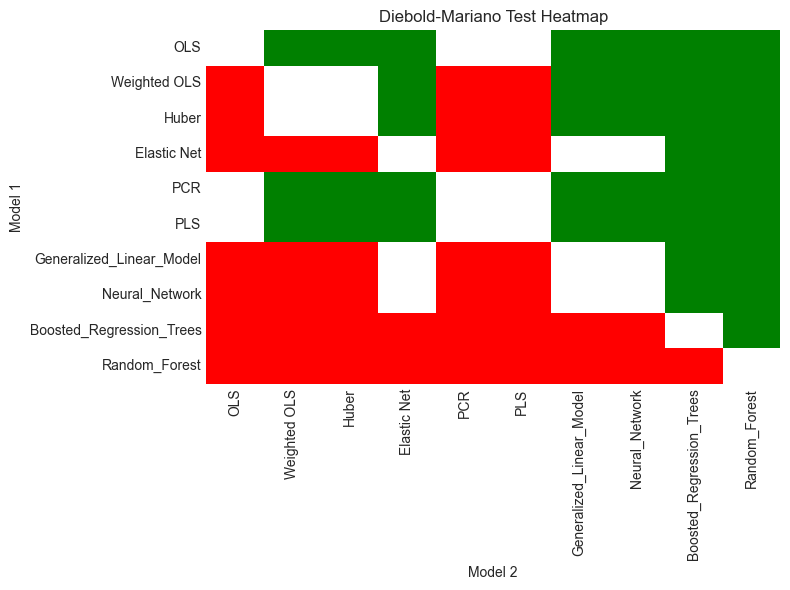

In [51]:
# Show the results in a heatmap

df_dm = pd.read_csv("/Users/dennis/Documents/Uni/FDS/PS6/data/diebold_mariano_results.csv")

# Pivot to matrix form
heatmap_matrix = np.empty((len(df_dm['Model1'].unique()), len(df_dm['Model2'].unique())), dtype=object)
model_names = df_dm['Model1'].unique()

for i, m1 in enumerate(model_names):
    for j, m2 in enumerate(model_names):
        if i == j:
            heatmap_matrix[i, j] = 'white'
            continue
        row = df_dm[(df_dm['Model1'] == m1) & (df_dm['Model2'] == m2)]
        pval = row['p-value'].values[0]
        dmstat = row['DM Statistic'].values[0]
        if pval > 0.05:
            heatmap_matrix[i, j] = 'white'
        elif pval <= 0.05 and dmstat < 0:
            heatmap_matrix[i, j] = 'green'
        else:
            heatmap_matrix[i, j] = 'red'

# Convert color matrix to numeric for plotting
color_map = {'white': 0, 'green': 1, 'red': 2}
numeric_matrix = np.vectorize(color_map.get)(heatmap_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(numeric_matrix, annot=False, cmap=sns.color_palette(['white', 'green', 'red']), 
            xticklabels=model_names, yticklabels=model_names, cbar=False)
plt.title('Diebold-Mariano Test Heatmap')
plt.xlabel('Model 2')
plt.ylabel('Model 1')
plt.tight_layout()
plt.savefig("images/diebold_mariano_heatmap.png")

# Variable Importance Calculations & Heatmaps

In [52]:
def variable_importance(X, Y, prediction):
    base_r2 = {name: calc_r2(Y, pred) for name, pred in prediction.items()}
    importance = {}
    for i in range(X.shape[1]):
        X_zerod = X.copy()
        X_zerod.iloc[:, i] = 0
        pred_drop = predict_all_models(X_zerod)
        r2_drop = {name: calc_r2(Y, pred) for name, pred in pred_drop.items()}
        importance[f'Var{i+1}'] = {name: base_r2[name] - r2_drop[name] for name in base_r2}
    return pd.DataFrame(importance).T

In [53]:
importance_df = variable_importance(X_test, Y_test, prediction)
importance_df.to_csv("/Users/dennis/Documents/Uni/FDS/PS6/data/variable_importance_results.csv", index=True)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step


In [54]:
sns.heatmap(importance_df, annot=True, cmap='viridis', xticklabels=importance_df.columns, yticklabels=importance_df.index)
plt.title('Variable Importance (Drop in R²) for All Models')
plt.tight_layout()
plt.savefig("images/variable_importance/variable_importance_all_models.png")
plt.close()

for col in importance_df.columns:
    plt.figure(figsize=(10, 6))
    sns.heatmap(importance_df[[col]].T, annot=True, cmap="viridis", cbar=True, fmt=".4f")
    plt.title(f'Variable Importance for {col}')
    plt.xlabel('Variables')
    plt.ylabel('Drop in R²')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"images/variable_importance/variable_importance_{col}.png")
    plt.close()

# Auxiliary Functions and Decile Portfolio Analysis

In [55]:
def decile_portfolio_analysis(Y_true, Y_pred):
    df = pd.DataFrame({'Actual': Y_true, 'Predicted': Y_pred})
    df['Decile'] = pd.qcut(df['Predicted'], 10, labels=False)
    results = df.groupby('Decile').agg({'Actual': ['mean', 'std'], 'Predicted': ['mean', 'std']})
    results['Sharpe_Actual'] = results['Actual']['mean'] / results['Actual']['std']
    results['Sharpe_Predicted'] = results['Predicted']['mean'] / results['Predicted']['std']
    return results

In [56]:

def plot_pred_vs_actual(results_df, name):
    plt.figure(figsize=(10, 6))
    actual = results_df['Actual']['mean']
    predicted = results_df['Predicted']['mean']
    
    plt.plot(actual.index, actual.values, marker='o', label='Tatsächliche Rendite')
    plt.plot(predicted.index, predicted.values, marker='x', label='Vorhergesagte Rendite')
    
    plt.title(f"Vorhergesagte vs. tatsächliche Renditen pro Dezil für {name}")
    plt.xlabel("Dezil (nach Prognose sortiert)")
    plt.ylabel("Durchschnittliche Rendite")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"images/pred_vs_actual_{name}.png")

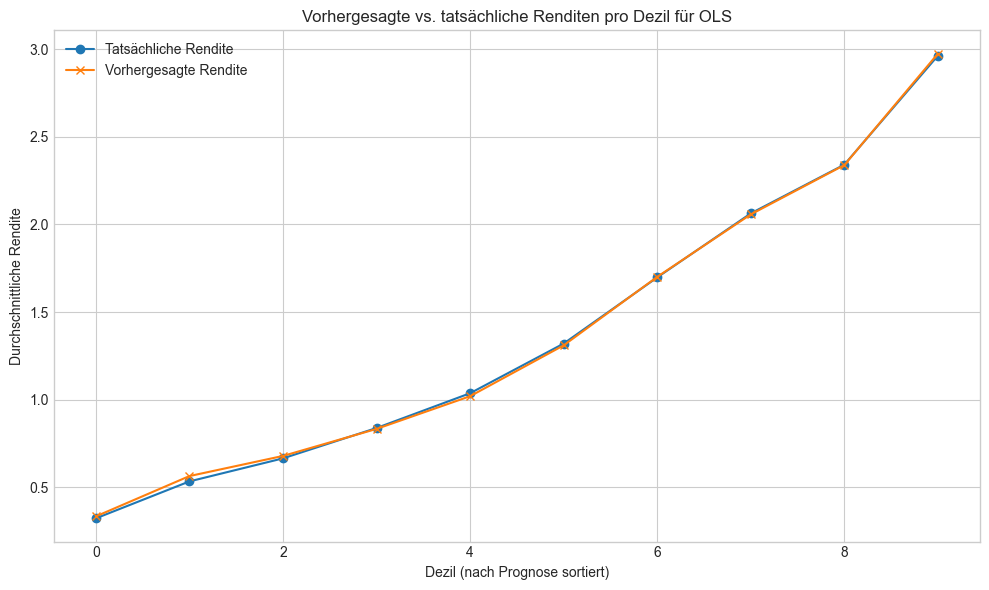

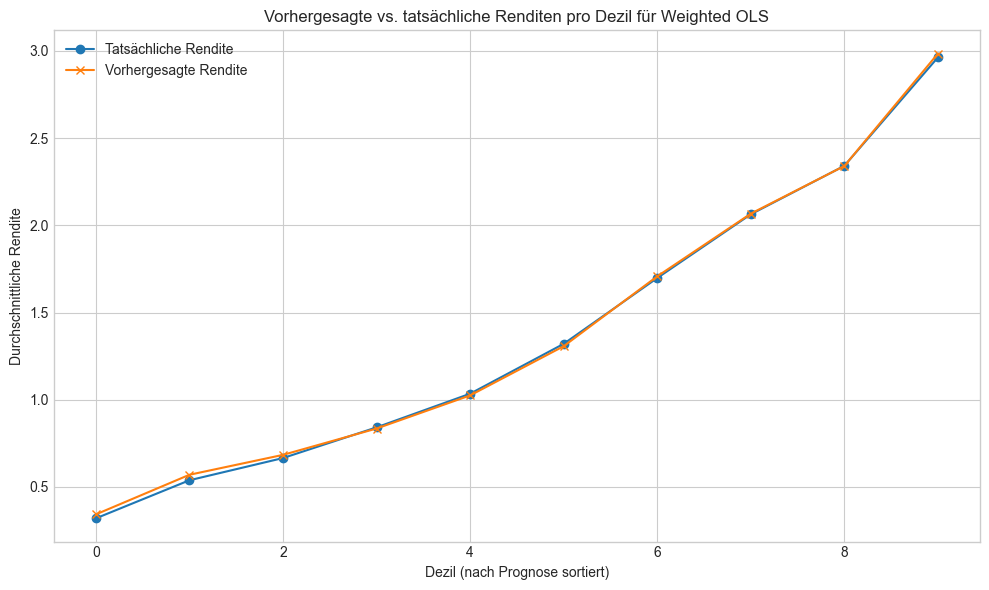

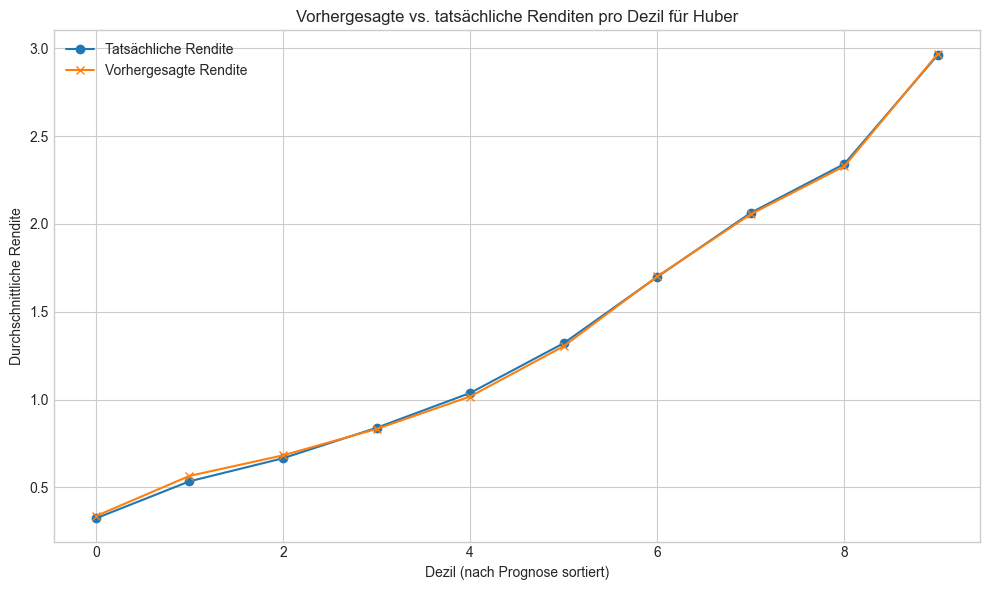

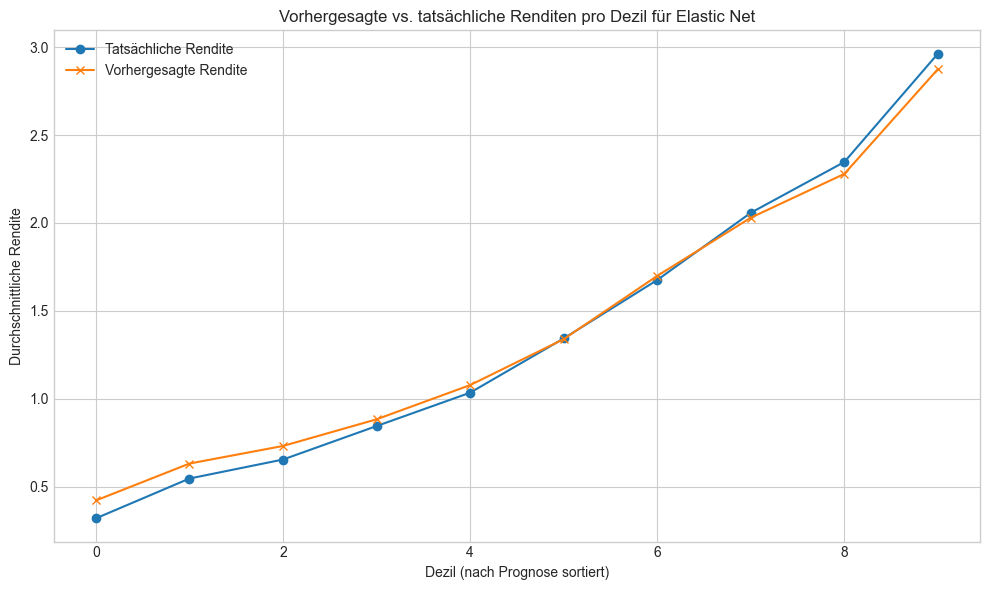

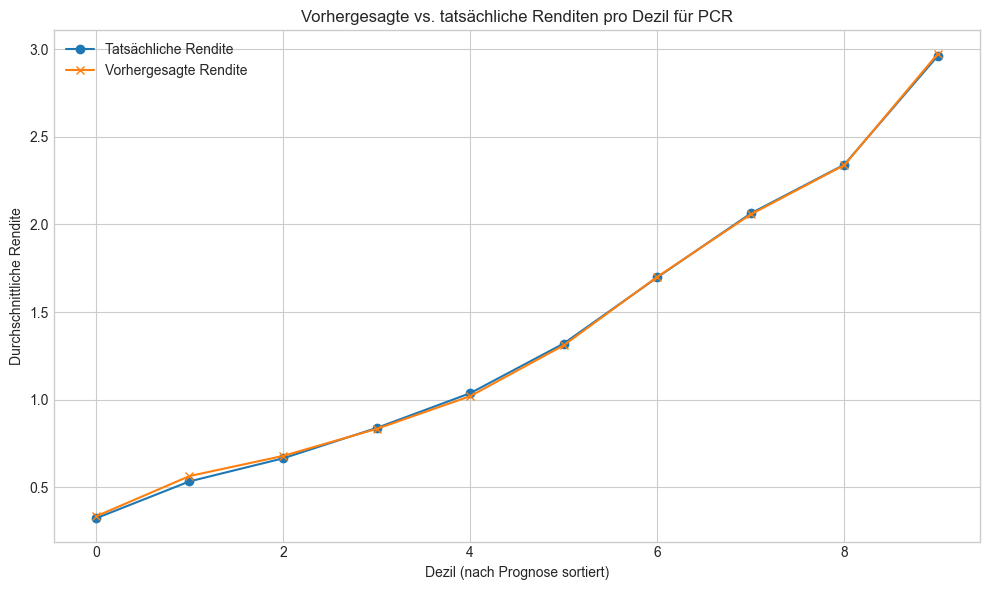

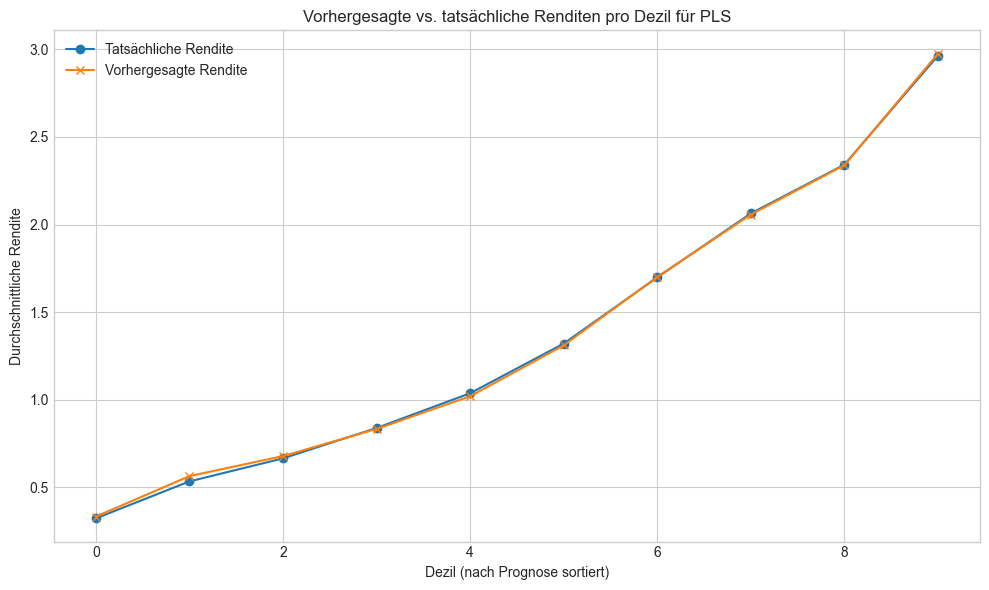

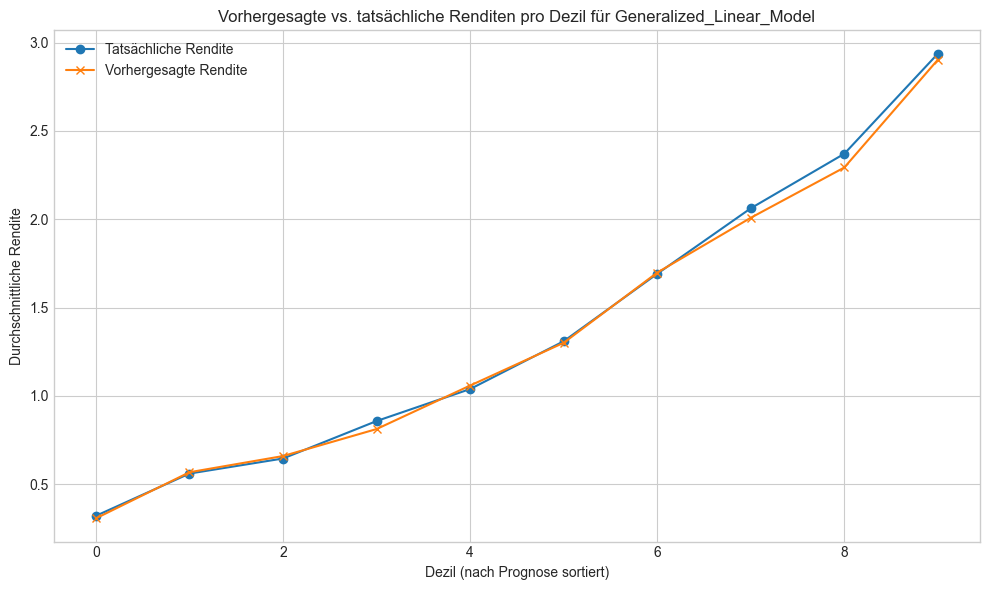

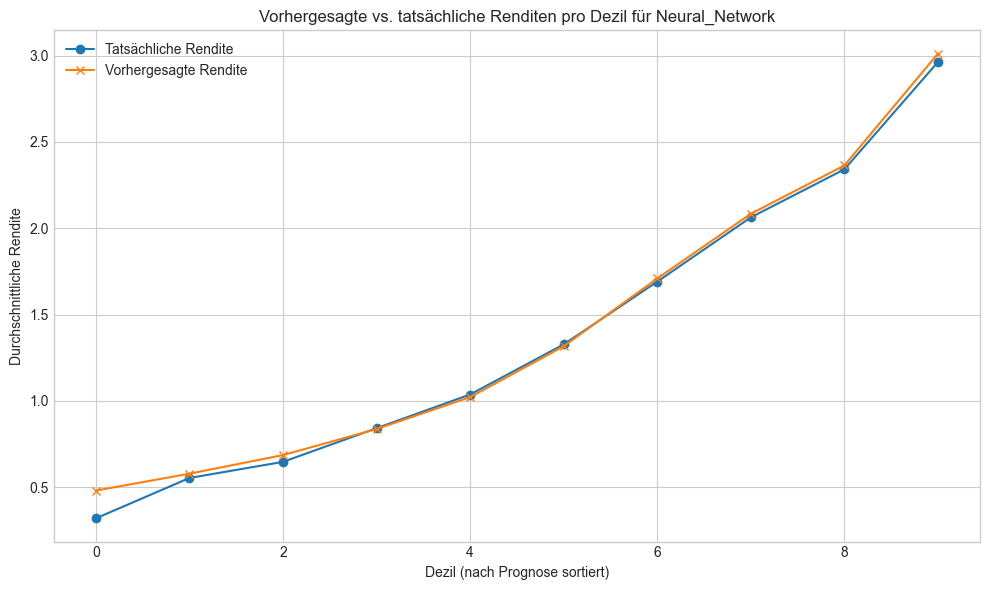

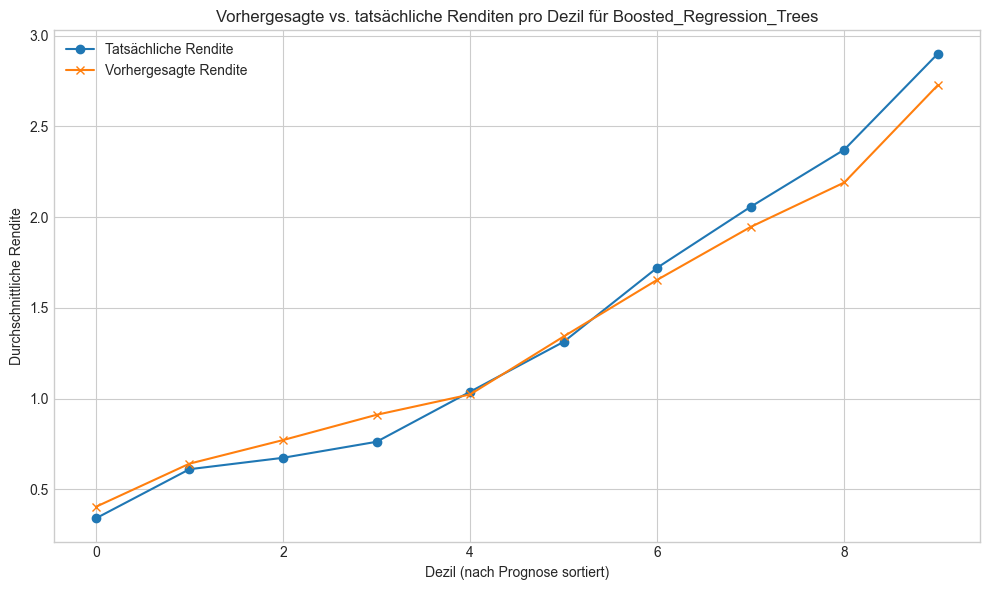

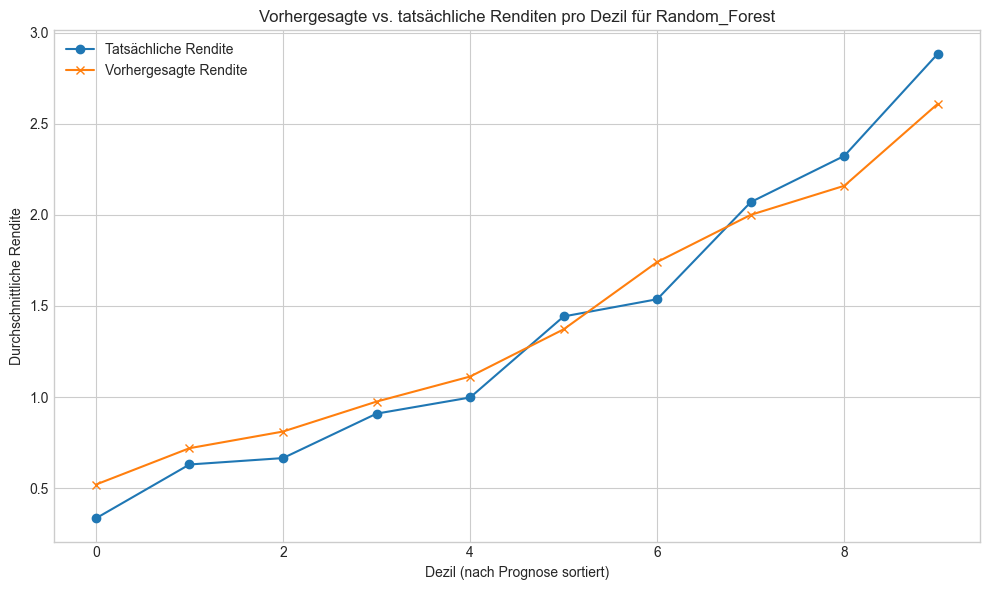

In [57]:
for name in list(prediction.keys()):
    df_decile = decile_portfolio_analysis(Y_test, prediction[name])
    df_decile.to_csv(f"data/decile_analysis_{name}.csv")
    plot_pred_vs_actual(df_decile, name)